# Linopy Battery Optimisation

In [20]:
from pathlib import Path
import timeit

import linopy
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [7]:
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


## NSW Energy Price Dec 2021

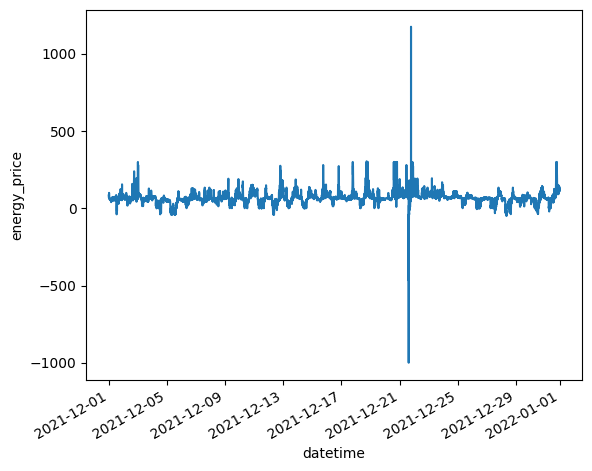

In [8]:
df = pd.read_parquet(Path.cwd().parent / "data")
df["SETTLEMENTDATE"] = pd.to_datetime(df["SETTLEMENTDATE"])
df = df.rename(columns={"SETTLEMENTDATE": "datetime", "RRP": "energy_price"})
df = df.query("INTERVENTION==0 and REGIONID=='NSW1'")
nsw_energy_price = df.set_index("datetime")["energy_price"].to_xarray()
nsw_energy_price.plot()

## Formulating the problem

Our mixed-integer linear program (MILP) formulation has one binary variable:

\begin{aligned}
\max_{t} \quad & \sum_{t=0}^T{\tau\lambda_t(p_t-q_t)}\\
\textrm{s.t.} \quad & u_t \in \{0,1\}    \\
& 0 \leq p_t \leq \bar{p}\\
& 0 \leq q_t \leq \bar{p} \\
& p_t - \bar{p}\left(1-u_t\right) \leq 0\\
& q_t - \bar{p}u_t \leq 0\\
& \underline{e} \leq e_t \leq \bar{e}    \\
& e_t-e_{t-1}- \left( q_t\eta_{charge}\tau\right)+\frac{p_t\tau}{\eta_{discharge}} = 0\\
& e_0 = 0.5\bar{e}\\
\end{aligned}

where:
- $\tau=\frac{1}{12} \textrm{hours}$
- $p_t$ corresponds to MW discharge at time $t$
- $q_t$ corresponds to MW charge at time $t$
- $u_t=1$ indicates charging, $u_t=0$ indicates discharging (*charge state*)
- $\bar{p}$ corresponds to the max power capacity in MW
- $\underline{e}$ and $\bar{e}$ corresponds to minimum and maximum state-of-charge limits, respectively
- $\lambda_t$ corresponds to the energy price in $/MWh at time $t$
- $\eta$ corresponds to efficiency (one term for charging and one term for discharging)

In [9]:
def create_linopy_model(nsw_energy_price: xr.DataArray, solver: str):
    power_cap = 30.0  # MW
    energy_cap = 30.0  # MWh
    soc_lower_limit = 0.1 * energy_cap  # MWh
    soc_upper_limit = 0.9 * energy_cap  # MWh
    charge_eff = 0.9  # unitless
    discharge_eff = 0.9  # unitless
    tau = 5.0 / 60.0  # minutes per hour
    # initial conditions
    initial_soc_mwh = 0.5 * energy_cap  # MWh

    m = linopy.Model()

    # variables
    discharge_mw = m.add_variables(
        lower=0.0, upper=power_cap, coords=nsw_energy_price.coords, name="discharge_mw"
    )
    charge_mw = m.add_variables(
        lower=0.0, upper=power_cap, coords=nsw_energy_price.coords, name="charge_mw"
    )
    charge_state = m.add_variables(
        binary=True, coords=nsw_energy_price.coords, name="charge_state"
    )
    soc_mwh = m.add_variables(
        lower=soc_lower_limit,
        upper=soc_upper_limit,
        coords=nsw_energy_price.coords,
        name="soc_mwh",
    )

    # state of operation constraints
    discharge_operation = m.add_constraints(
        discharge_mw + power_cap * charge_state <= power_cap,
        name="discharging-operation",
    )
    charge_operation = m.add_constraints(
        charge_mw - power_cap * charge_state <= 0, name="charging-operation"
    )
    # intertemporal energy balance constraints
    # scalar * variable or variable * scalar required at this stage
    # last isel gathers vectorised constraints from t=1 onwwards (excluding t=0)
    intertemp_soc_lhs = (
        soc_mwh
        - soc_mwh.shift(datetime=1)
        - charge_mw * (charge_eff * tau)
        + discharge_mw * (tau / discharge_eff)
    ).isel(datetime=slice(1, None))
    intertemp_soc = m.add_constraints(
        intertemp_soc_lhs, "=", 0, "intemporal-energy-balance"
    )
    # initial SoC constraint
    initial_soc = m.add_constraints(
        soc_mwh.isel(datetime=0) == initial_soc_mwh, name="initial-soc"
    )
    # objective - add negative sign as linopy only permits minimisation
    obj = (nsw_energy_price * tau * (-1 * discharge_mw + charge_mw)).sum()
    m.add_objective(obj)
    m.solve(solver)
    return m

In [10]:
model = create_linopy_model(nsw_energy_price, "gurobi")

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 125.53it/s]


Read LP format model from file /tmp/linopy-problem-hnew53se.lp
Reading time = 0.07 seconds
obj: 26784 rows, 35712 columns, 71421 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 26784 rows, 35712 columns and 71421 nonzeros
Model fingerprint: 0x36d1bdd7
Variable types: 26784 continuous, 8928 integer (8928 binary)
Coefficient statistics:
  Matrix range     [7e-02, 3e+01]
  Objective range  [1e-06, 1e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [2e+01, 3e+01]
Found heuristic solution: objective -988.7017550
Presolve removed 6 rows and 7 columns
Presolve time: 0.05s
Presolved: 26778 rows, 35705 columns, 71409 nonzeros
Variable types: 26778 continuous, 8927 integer (8927 binary)

Root relaxation: objective -1.719009e+05, 6185 iterations, 1.83 seconds (9.61 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  

## Bechmarking

In [16]:
t_g = timeit.timeit(lambda: create_linopy_model(nsw_energy_price, "gurobi"), number=10)
print(t_g / 10)

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 298.06it/s]

Read LP format model from file /tmp/linopy-problem-k277zhdn.lp
Reading time = 0.06 seconds
obj: 26784 rows, 35712 columns, 71421 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 26784 rows, 35712 columns and 71421 nonzeros
Model fingerprint: 0x36d1bdd7
Variable types: 26784 continuous, 8928 integer (8928 binary)
Coefficient statistics:
  Matrix range     [7e-02, 3e+01]
  Objective range  [1e-06, 1e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [2e+01, 3e+01]
Found heuristic solution: objective -988.7017550


Presolve removed 6 rows and 7 columns
Presolve time: 0.06s
Presolved: 26778 rows, 35705 columns, 71409 nonzeros
Variable types: 26778 continuous, 8927 integer (8927 binary)

Root relaxation: objective -1.719009e+05, 6185 iterations, 1.81 seconds (9.61 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -171900.94    0   17 -988.70175 -171900.94      -     -    1s
H    0     0                    -171879.3144 -171900.94  0.01%     -    2s
     0     0 -171892.94    0    5 -171879.31 -171892.94  0.01%     -    2s

Cutting planes:
  Gomory: 10
  MIR: 31
  Flow cover: 24
  Relax-and-lift: 3

Explored 1 nodes (7958 simplex iterations) in 2.17 seconds (9.83 work units)
Thread count was 20 (of 20 available processors)

Solution count 2: -171879 -988.702 

Optimal solution found (tolerance 1.00e-04)
Best objective -1.718793144081e+05, best bound -1.718929423333e+05, gap 0

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 135.00it/s]


Read LP format model from file /tmp/linopy-problem-gw74q1ue.lp
Reading time = 0.07 seconds
obj: 26784 rows, 35712 columns, 71421 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 26784 rows, 35712 columns and 71421 nonzeros
Model fingerprint: 0x36d1bdd7
Variable types: 26784 continuous, 8928 integer (8928 binary)
Coefficient statistics:
  Matrix range     [7e-02, 3e+01]
  Objective range  [1e-06, 1e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [2e+01, 3e+01]
Found heuristic solution: objective -988.7017550
Presolve removed 6 rows and 7 columns
Presolve time: 0.09s
Presolved: 26778 rows, 35705 columns, 71409 nonzeros
Variable types: 26778 continuous, 8927 integer (8927 binary)

Root relaxation: objective -1.719009e+05, 6185 iterations, 1.78 seconds (9.61 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 118.16it/s]


Read LP format model from file /tmp/linopy-problem-nr25fdi3.lp
Reading time = 0.10 seconds
obj: 26784 rows, 35712 columns, 71421 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 26784 rows, 35712 columns and 71421 nonzeros
Model fingerprint: 0x36d1bdd7
Variable types: 26784 continuous, 8928 integer (8928 binary)
Coefficient statistics:
  Matrix range     [7e-02, 3e+01]
  Objective range  [1e-06, 1e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [2e+01, 3e+01]
Found heuristic solution: objective -988.7017550
Presolve removed 6 rows and 7 columns
Presolve time: 0.08s
Presolved: 26778 rows, 35705 columns, 71409 nonzeros
Variable types: 26778 continuous, 8927 integer (8927 binary)

Root relaxation: objective -1.719009e+05, 6185 iterations, 1.82 seconds (9.61 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 376.75it/s]

Read LP format model from file /tmp/linopy-problem-n00a9l1a.lp
Reading time = 0.06 seconds


obj: 26784 rows, 35712 columns, 71421 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 26784 rows, 35712 columns and 71421 nonzeros
Model fingerprint: 0x36d1bdd7
Variable types: 26784 continuous, 8928 integer (8928 binary)
Coefficient statistics:
  Matrix range     [7e-02, 3e+01]
  Objective range  [1e-06, 1e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [2e+01, 3e+01]
Found heuristic solution: objective -988.7017550
Presolve removed 6 rows and 7 columns
Presolve time: 0.07s
Presolved: 26778 rows, 35705 columns, 71409 nonzeros
Variable types: 26778 continuous, 8927 integer (8927 binary)

Root relaxation: objective -1.719009e+05, 6185 iterations, 1.87 seconds (9.61 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -171900.94    0   17 

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 392.87it/s]

Read LP format model from file /tmp/linopy-problem-36mca8bl.lp
Reading time = 0.06 seconds
obj: 26784 rows, 35712 columns, 71421 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 26784 rows, 35712 columns and 71421 nonzeros
Model fingerprint: 0x36d1bdd7
Variable types: 26784 continuous, 8928 integer (8928 binary)
Coefficient statistics:
  Matrix range     [7e-02, 3e+01]
  Objective range  [1e-06, 1e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [2e+01, 3e+01]
Found heuristic solution: objective -988.7017550


Presolve removed 6 rows and 7 columns
Presolve time: 0.08s
Presolved: 26778 rows, 35705 columns, 71409 nonzeros
Variable types: 26778 continuous, 8927 integer (8927 binary)

Root relaxation: objective -1.719009e+05, 6185 iterations, 1.80 seconds (9.61 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -171900.94    0   17 -988.70175 -171900.94      -     -    2s
H    0     0                    -171879.3144 -171900.94  0.01%     -    2s
     0     0 -171892.94    0    5 -171879.31 -171892.94  0.01%     -    2s

Cutting planes:
  Gomory: 10
  MIR: 31
  Flow cover: 24
  Relax-and-lift: 3

Explored 1 nodes (7958 simplex iterations) in 2.19 seconds (9.83 work units)
Thread count was 20 (of 20 available processors)

Solution count 2: -171879 -988.702 

Optimal solution found (tolerance 1.00e-04)
Best objective -1.718793144081e+05, best bound -1.718929423333e+05, gap 0

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 147.58it/s]


Read LP format model from file /tmp/linopy-problem-_0lhc788.lp
Reading time = 0.09 seconds
obj: 26784 rows, 35712 columns, 71421 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 26784 rows, 35712 columns and 71421 nonzeros
Model fingerprint: 0x36d1bdd7
Variable types: 26784 continuous, 8928 integer (8928 binary)
Coefficient statistics:
  Matrix range     [7e-02, 3e+01]
  Objective range  [1e-06, 1e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [2e+01, 3e+01]
Found heuristic solution: objective -988.7017550
Presolve removed 6 rows and 7 columns
Presolve time: 0.05s
Presolved: 26778 rows, 35705 columns, 71409 nonzeros
Variable types: 26778 continuous, 8927 integer (8927 binary)

Root relaxation: objective -1.719009e+05, 6185 iterations, 1.81 seconds (9.61 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 366.54it/s]

Read LP format model from file /tmp/linopy-problem-6v08ucs2.lp
Reading time = 0.07 seconds
obj: 26784 rows, 35712 columns, 71421 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 26784 rows, 35712 columns and 71421 nonzeros
Model fingerprint: 0x36d1bdd7
Variable types: 26784 continuous, 8928 integer (8928 binary)
Coefficient statistics:
  Matrix range     [7e-02, 3e+01]
  Objective range  [1e-06, 1e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [2e+01, 3e+01]
Found heuristic solution: objective -988.7017550


Presolve removed 6 rows and 7 columns
Presolve time: 0.08s
Presolved: 26778 rows, 35705 columns, 71409 nonzeros
Variable types: 26778 continuous, 8927 integer (8927 binary)

Root relaxation: objective -1.719009e+05, 6185 iterations, 1.88 seconds (9.61 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -171900.94    0   17 -988.70175 -171900.94      -     -    2s
H    0     0                    -171879.3144 -171900.94  0.01%     -    2s
     0     0 -171892.94    0    5 -171879.31 -171892.94  0.01%     -    2s

Cutting planes:
  Gomory: 10
  MIR: 31
  Flow cover: 24
  Relax-and-lift: 3

Explored 1 nodes (7958 simplex iterations) in 2.28 seconds (9.83 work units)
Thread count was 20 (of 20 available processors)

Solution count 2: -171879 -988.702 

Optimal solution found (tolerance 1.00e-04)
Best objective -1.718793144081e+05, best bound -1.718929423333e+05, gap 0

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 397.87it/s]

Read LP format model from file /tmp/linopy-problem-utbf1zs2.lp
Reading time = 0.06 seconds
obj: 26784 rows, 35712 columns, 71421 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 26784 rows, 35712 columns and 71421 nonzeros
Model fingerprint: 0x36d1bdd7
Variable types: 26784 continuous, 8928 integer (8928 binary)
Coefficient statistics:
  Matrix range     [7e-02, 3e+01]
  Objective range  [1e-06, 1e+02]
  Bounds range     [1e+00, 3e+01]


  RHS range        [2e+01, 3e+01]
Found heuristic solution: objective -988.7017550
Presolve removed 6 rows and 7 columns
Presolve time: 0.08s
Presolved: 26778 rows, 35705 columns, 71409 nonzeros
Variable types: 26778 continuous, 8927 integer (8927 binary)

Root relaxation: objective -1.719009e+05, 6185 iterations, 1.85 seconds (9.61 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -171900.94    0   17 -988.70175 -171900.94      -     -    2s
H    0     0                    -171879.3144 -171900.94  0.01%     -    2s
     0     0 -171892.94    0    5 -171879.31 -171892.94  0.01%     -    2s

Cutting planes:
  Gomory: 10
  MIR: 31
  Flow cover: 24
  Relax-and-lift: 3

Explored 1 nodes (7958 simplex iterations) in 2.27 seconds (9.83 work units)
Thread count was 20 (of 20 available processors)

Solution count 2: -171879 -988.702 

Optimal solution found (tolerance 

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 125.39it/s]


Read LP format model from file /tmp/linopy-problem-247vdb_e.lp
Reading time = 0.08 seconds
obj: 26784 rows, 35712 columns, 71421 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 26784 rows, 35712 columns and 71421 nonzeros
Model fingerprint: 0x36d1bdd7
Variable types: 26784 continuous, 8928 integer (8928 binary)
Coefficient statistics:
  Matrix range     [7e-02, 3e+01]
  Objective range  [1e-06, 1e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [2e+01, 3e+01]
Found heuristic solution: objective -988.7017550
Presolve removed 6 rows and 7 columns
Presolve time: 0.07s
Presolved: 26778 rows, 35705 columns, 71409 nonzeros
Variable types: 26778 continuous, 8927 integer (8927 binary)

Root relaxation: objective -1.719009e+05, 6185 iterations, 1.83 seconds (9.61 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 411.85it/s]

Read LP format model from file /tmp/linopy-problem-gwq6jz1c.lp
Reading time = 0.06 seconds
obj: 26784 rows, 35712 columns, 71421 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 26784 rows, 35712 columns and 71421 nonzeros
Model fingerprint: 0x36d1bdd7
Variable types: 26784 continuous, 8928 integer (8928 binary)
Coefficient statistics:
  Matrix range     [7e-02, 3e+01]
  Objective range  [1e-06, 1e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [2e+01, 3e+01]
Found heuristic solution: objective -988.7017550


Presolve removed 6 rows and 7 columns
Presolve time: 0.06s
Presolved: 26778 rows, 35705 columns, 71409 nonzeros
Variable types: 26778 continuous, 8927 integer (8927 binary)

Root relaxation: objective -1.719009e+05, 6185 iterations, 1.82 seconds (9.61 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -171900.94    0   17 -988.70175 -171900.94      -     -    2s
H    0     0                    -171879.3144 -171900.94  0.01%     -    2s
     0     0 -171892.94    0    5 -171879.31 -171892.94  0.01%     -    2s

Cutting planes:
  Gomory: 10
  MIR: 31
  Flow cover: 24
  Relax-and-lift: 3

Explored 1 nodes (7958 simplex iterations) in 2.20 seconds (9.83 work units)
Thread count was 20 (of 20 available processors)

Solution count 2: -171879 -988.702 

Optimal solution found (tolerance 1.00e-04)
Best objective -1.718793144081e+05, best bound -1.718929423333e+05, gap 0

2.6767269318006583


In [17]:
t_c = timeit.timeit(lambda: create_linopy_model(nsw_energy_price, "cbc"), number=10)
print(t_c / 10)

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 113.67it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - cbc -printingOptions all -import /tmp/linopy-problem-hyst4xe7.lp -solve -solu /tmp/linopy-solve-kvgngwcz.sol  (default strategy 1)
Option for printingOptions changed from normal to all
Continuous objective value is -171901 - 0.44 seconds
Cgl0004I processed model has 26777 rows, 35703 columns (8927 integer (8927 of which binary)) and 71406 elements
Cbc0038I Initial state - 195 integers unsatisfied sum - 53.649
Cbc0038I Pass   1: (0.68 seconds) suminf.    0.00000 (0) obj. -171401 iterations 2319
Cbc0038I Solution found of -171401
Cbc0038I Relaxing continuous gives -171573
Cbc0038I Before mini branch and bound, 8732 integers at bound fixed and 20449 continuous
Cbc0038I Full problem 26777 rows 35703 columns, reduced to 75 rows 144 columns
Cbc0038I Mini branch and bound improved solution from -171573 to -171880 (0.78 seconds)
Cbc0038I Round again with cutoff of -171882
Cbc0038I Reduced cost fixing fixe

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 109.90it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - cbc -printingOptions all -import /tmp/linopy-problem-clwic88c.lp -solve -solu /tmp/linopy-solve-pseru2mo.sol  (default strategy 1)
Option for printingOptions changed from normal to all
Continuous objective value is -171901 - 0.42 seconds
Cgl0004I processed model has 26777 rows, 35703 columns (8927 integer (8927 of which binary)) and 71406 elements
Cbc0038I Initial state - 195 integers unsatisfied sum - 53.649
Cbc0038I Pass   1: (0.65 seconds) suminf.    0.00000 (0) obj. -171401 iterations 2319
Cbc0038I Solution found of -171401
Cbc0038I Relaxing continuous gives -171573
Cbc0038I Before mini branch and bound, 8732 integers at bound fixed and 20449 continuous
Cbc0038I Full problem 26777 rows 35703 columns, reduced to 75 rows 144 columns
Cbc0038I Mini branch and bound improved solution from -171573 to -171880 (0.75 seconds)
Cbc0038I Round again with cutoff of -171882
Cbc0038I Reduced cost fixing fixe

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 128.82it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - cbc -printingOptions all -import /tmp/linopy-problem-ykbu2eo0.lp -solve -solu /tmp/linopy-solve-jyw88ko8.sol  (default strategy 1)
Option for printingOptions changed from normal to all
Continuous objective value is -171901 - 0.43 seconds
Cgl0004I processed model has 26777 rows, 35703 columns (8927 integer (8927 of which binary)) and 71406 elements
Cbc0038I Initial state - 195 integers unsatisfied sum - 53.649
Cbc0038I Pass   1: (0.69 seconds) suminf.    0.00000 (0) obj. -171401 iterations 2319
Cbc0038I Solution found of -171401
Cbc0038I Relaxing continuous gives -171573
Cbc0038I Before mini branch and bound, 8732 integers at bound fixed and 20449 continuous
Cbc0038I Full problem 26777 rows 35703 columns, reduced to 75 rows 144 columns
Cbc0038I Mini branch and bound improved solution from -171573 to -171880 (0.79 seconds)
Cbc0038I Round again with cutoff of -171882
Cbc0038I Reduced cost fixing fixe

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 120.86it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - cbc -printingOptions all -import /tmp/linopy-problem-u3xlgf95.lp -solve -solu /tmp/linopy-solve-mqis4ofo.sol  (default strategy 1)
Option for printingOptions changed from normal to all
Continuous objective value is -171901 - 0.40 seconds
Cgl0004I processed model has 26777 rows, 35703 columns (8927 integer (8927 of which binary)) and 71406 elements
Cbc0038I Initial state - 195 integers unsatisfied sum - 53.649
Cbc0038I Pass   1: (0.64 seconds) suminf.    0.00000 (0) obj. -171401 iterations 2319
Cbc0038I Solution found of -171401
Cbc0038I Relaxing continuous gives -171573
Cbc0038I Before mini branch and bound, 8732 integers at bound fixed and 20449 continuous
Cbc0038I Full problem 26777 rows 35703 columns, reduced to 75 rows 144 columns
Cbc0038I Mini branch and bound improved solution from -171573 to -171880 (0.74 seconds)
Cbc0038I Round again with cutoff of -171882
Cbc0038I Reduced cost fixing fixe

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 114.73it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - cbc -printingOptions all -import /tmp/linopy-problem-n9vx4pz7.lp -solve -solu /tmp/linopy-solve-d5suiot9.sol  (default strategy 1)
Option for printingOptions changed from normal to all
Continuous objective value is -171901 - 0.40 seconds
Cgl0004I processed model has 26777 rows, 35703 columns (8927 integer (8927 of which binary)) and 71406 elements
Cbc0038I Initial state - 195 integers unsatisfied sum - 53.649
Cbc0038I Pass   1: (0.66 seconds) suminf.    0.00000 (0) obj. -171401 iterations 2319
Cbc0038I Solution found of -171401
Cbc0038I Relaxing continuous gives -171573
Cbc0038I Before mini branch and bound, 8732 integers at bound fixed and 20449 continuous
Cbc0038I Full problem 26777 rows 35703 columns, reduced to 75 rows 144 columns
Cbc0038I Mini branch and bound improved solution from -171573 to -171880 (0.75 seconds)
Cbc0038I Round again with cutoff of -171882
Cbc0038I Reduced cost fixing fixe

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 103.15it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - cbc -printingOptions all -import /tmp/linopy-problem-q5rcak87.lp -solve -solu /tmp/linopy-solve-b_4d89uf.sol  (default strategy 1)
Option for printingOptions changed from normal to all
Continuous objective value is -171901 - 0.43 seconds
Cgl0004I processed model has 26777 rows, 35703 columns (8927 integer (8927 of which binary)) and 71406 elements
Cbc0038I Initial state - 195 integers unsatisfied sum - 53.649
Cbc0038I Pass   1: (0.66 seconds) suminf.    0.00000 (0) obj. -171401 iterations 2319
Cbc0038I Solution found of -171401
Cbc0038I Relaxing continuous gives -171573
Cbc0038I Before mini branch and bound, 8732 integers at bound fixed and 20449 continuous
Cbc0038I Full problem 26777 rows 35703 columns, reduced to 75 rows 144 columns
Cbc0038I Mini branch and bound improved solution from -171573 to -171880 (0.75 seconds)
Cbc0038I Round again with cutoff of -171882
Cbc0038I Reduced cost fixing fixe

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 118.52it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - cbc -printingOptions all -import /tmp/linopy-problem-216_vf6j.lp -solve -solu /tmp/linopy-solve-irp0z99k.sol  (default strategy 1)
Option for printingOptions changed from normal to all
Continuous objective value is -171901 - 0.42 seconds
Cgl0004I processed model has 26777 rows, 35703 columns (8927 integer (8927 of which binary)) and 71406 elements
Cbc0038I Initial state - 195 integers unsatisfied sum - 53.649
Cbc0038I Pass   1: (0.66 seconds) suminf.    0.00000 (0) obj. -171401 iterations 2319
Cbc0038I Solution found of -171401
Cbc0038I Relaxing continuous gives -171573
Cbc0038I Before mini branch and bound, 8732 integers at bound fixed and 20449 continuous
Cbc0038I Full problem 26777 rows 35703 columns, reduced to 75 rows 144 columns
Cbc0038I Mini branch and bound improved solution from -171573 to -171880 (0.76 seconds)
Cbc0038I Round again with cutoff of -171882
Cbc0038I Reduced cost fixing fixe

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 117.80it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - cbc -printingOptions all -import /tmp/linopy-problem-2xckbvby.lp -solve -solu /tmp/linopy-solve-fgt8g68p.sol  (default strategy 1)
Option for printingOptions changed from normal to all
Continuous objective value is -171901 - 0.40 seconds
Cgl0004I processed model has 26777 rows, 35703 columns (8927 integer (8927 of which binary)) and 71406 elements
Cbc0038I Initial state - 195 integers unsatisfied sum - 53.649
Cbc0038I Pass   1: (0.63 seconds) suminf.    0.00000 (0) obj. -171401 iterations 2319
Cbc0038I Solution found of -171401
Cbc0038I Relaxing continuous gives -171573
Cbc0038I Before mini branch and bound, 8732 integers at bound fixed and 20449 continuous
Cbc0038I Full problem 26777 rows 35703 columns, reduced to 75 rows 144 columns
Cbc0038I Mini branch and bound improved solution from -171573 to -171880 (0.72 seconds)
Cbc0038I Round again with cutoff of -171882
Cbc0038I Reduced cost fixing fixe

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 380.71it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - cbc -printingOptions all -import /tmp/linopy-problem-fmxawdlr.lp -solve -solu /tmp/linopy-solve-8fjjv1su.sol  (default strategy 1)
Option for printingOptions changed from normal to all
Continuous objective value is -171901 - 0.41 seconds
Cgl0004I processed model has 26777 rows, 35703 columns (8927 integer (8927 of which binary)) and 71406 elements
Cbc0038I Initial state - 195 integers unsatisfied sum - 53.649
Cbc0038I Pass   1: (0.62 seconds) suminf.    0.00000 (0) obj. -171401 iterations 2319
Cbc0038I Solution found of -171401
Cbc0038I Relaxing continuous gives -171573
Cbc0038I Before mini branch and bound, 8732 integers at bound fixed and 20449 continuous
Cbc0038I Full problem 26777 rows 35703 columns, reduced to 75 rows 144 columns
Cbc0038I Mini branch and bound improved solution from -171573 to -171880 (0.73 seconds)
Cbc0038I Round again with cutoff of -171882
Cbc0038I Reduced cost fixing fixe

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 189.20it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - cbc -printingOptions all -import /tmp/linopy-problem-y6ntvnnf.lp -solve -solu /tmp/linopy-solve-276mie48.sol  (default strategy 1)
Option for printingOptions changed from normal to all
Continuous objective value is -171901 - 0.41 seconds
Cgl0004I processed model has 26777 rows, 35703 columns (8927 integer (8927 of which binary)) and 71406 elements
Cbc0038I Initial state - 195 integers unsatisfied sum - 53.649
Cbc0038I Pass   1: (0.65 seconds) suminf.    0.00000 (0) obj. -171401 iterations 2319
Cbc0038I Solution found of -171401
Cbc0038I Relaxing continuous gives -171573
Cbc0038I Before mini branch and bound, 8732 integers at bound fixed and 20449 continuous
Cbc0038I Full problem 26777 rows 35703 columns, reduced to 75 rows 144 columns
Cbc0038I Mini branch and bound improved solution from -171573 to -171880 (0.75 seconds)
Cbc0038I Round again with cutoff of -171882
Cbc0038I Reduced cost fixing fixe

In [19]:
t_h = timeit.timeit(lambda: create_linopy_model(nsw_energy_price, "highs"), number=10)
print(t_h / 10)

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 344.33it/s]


Running HiGHS 1.2.2 [date: 2022-09-04, git hash: 8701dbf19]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
26783 rows, 35710 cols, 71418 nonzeros
26780 rows, 35707 cols, 71413 nonzeros

Solving MIP model with:
   26780 rows
   35707 cols (8927 binary, 0 integer, 0 implied int., 26780 continuous)
   71413 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   -1545369.54336  inf                  inf        0      0      0         0     0.1s
 R       0       0         0   0.00%   -171900.938886  -171373.538036     0.31%        0      0      0     12737     0.5s
 C       0       0         0   0.00%   -171890.254319  -171573.161439     0.18%      703    328      0     13234     1.6s
 L       0       0         0   0.00%   -171886.607

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 105.55it/s]


Running HiGHS 1.2.2 [date: 2022-09-04, git hash: 8701dbf19]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
26783 rows, 35710 cols, 71418 nonzeros
26780 rows, 35707 cols, 71413 nonzeros

Solving MIP model with:
   26780 rows
   35707 cols (8927 binary, 0 integer, 0 implied int., 26780 continuous)
   71413 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   -1545369.54336  inf                  inf        0      0      0         0     0.1s
 R       0       0         0   0.00%   -171900.938886  -171373.538036     0.31%        0      0      0     12737     0.5s
 C       0       0         0   0.00%   -171890.254319  -171573.161439     0.18%      703    328      0     13234     1.7s
 L       0       0         0   0.00%   -171886.607

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 372.10it/s]


Running HiGHS 1.2.2 [date: 2022-09-04, git hash: 8701dbf19]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
26783 rows, 35710 cols, 71418 nonzeros
26780 rows, 35707 cols, 71413 nonzeros

Solving MIP model with:
   26780 rows
   35707 cols (8927 binary, 0 integer, 0 implied int., 26780 continuous)
   71413 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   -1545369.54336  inf                  inf        0      0      0         0     0.1s
 R       0       0         0   0.00%   -171900.938886  -171373.538036     0.31%        0      0      0     12737     0.5s
 C       0       0         0   0.00%   -171890.254319  -171573.161439     0.18%      703    328      0     13234     1.6s
 L       0       0         0   0.00%   -171886.607

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 319.08it/s]


Running HiGHS 1.2.2 [date: 2022-09-04, git hash: 8701dbf19]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
26783 rows, 35710 cols, 71418 nonzeros
26780 rows, 35707 cols, 71413 nonzeros

Solving MIP model with:
   26780 rows
   35707 cols (8927 binary, 0 integer, 0 implied int., 26780 continuous)
   71413 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   -1545369.54336  inf                  inf        0      0      0         0     0.1s
 R       0       0         0   0.00%   -171900.938886  -171373.538036     0.31%        0      0      0     12737     0.5s
 C       0       0         0   0.00%   -171890.254319  -171573.161439     0.18%      703    328      0     13234     1.7s
 L       0       0         0   0.00%   -171886.607

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 385.75it/s]


Running HiGHS 1.2.2 [date: 2022-09-04, git hash: 8701dbf19]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
26783 rows, 35710 cols, 71418 nonzeros
26780 rows, 35707 cols, 71413 nonzeros

Solving MIP model with:
   26780 rows
   35707 cols (8927 binary, 0 integer, 0 implied int., 26780 continuous)
   71413 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   -1545369.54336  inf                  inf        0      0      0         0     0.1s
 R       0       0         0   0.00%   -171900.938886  -171373.538036     0.31%        0      0      0     12737     0.5s
 C       0       0         0   0.00%   -171890.254319  -171573.161439     0.18%      703    328      0     13234     1.6s
 L       0       0         0   0.00%   -171886.607

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 117.18it/s]


Running HiGHS 1.2.2 [date: 2022-09-04, git hash: 8701dbf19]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
26783 rows, 35710 cols, 71418 nonzeros
26780 rows, 35707 cols, 71413 nonzeros

Solving MIP model with:
   26780 rows
   35707 cols (8927 binary, 0 integer, 0 implied int., 26780 continuous)
   71413 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   -1545369.54336  inf                  inf        0      0      0         0     0.1s
 R       0       0         0   0.00%   -171900.938886  -171373.538036     0.31%        0      0      0     12737     0.5s
 C       0       0         0   0.00%   -171890.254319  -171573.161439     0.18%      703    328      0     13234     1.6s
 L       0       0         0   0.00%   -171886.607

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 120.62it/s]


Running HiGHS 1.2.2 [date: 2022-09-04, git hash: 8701dbf19]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
26783 rows, 35710 cols, 71418 nonzeros
26780 rows, 35707 cols, 71413 nonzeros

Solving MIP model with:
   26780 rows
   35707 cols (8927 binary, 0 integer, 0 implied int., 26780 continuous)
   71413 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   -1545369.54336  inf                  inf        0      0      0         0     0.1s
 R       0       0         0   0.00%   -171900.938886  -171373.538036     0.31%        0      0      0     12737     0.5s
 C       0       0         0   0.00%   -171890.254319  -171573.161439     0.18%      703    328      0     13234     1.6s
 L       0       0         0   0.00%   -171886.607

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 127.15it/s]


Running HiGHS 1.2.2 [date: 2022-09-04, git hash: 8701dbf19]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
26783 rows, 35710 cols, 71418 nonzeros
26780 rows, 35707 cols, 71413 nonzeros

Solving MIP model with:
   26780 rows
   35707 cols (8927 binary, 0 integer, 0 implied int., 26780 continuous)
   71413 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   -1545369.54336  inf                  inf        0      0      0         0     0.1s
 R       0       0         0   0.00%   -171900.938886  -171373.538036     0.31%        0      0      0     12737     0.5s
 C       0       0         0   0.00%   -171890.254319  -171573.161439     0.18%      703    328      0     13234     1.6s
 L       0       0         0   0.00%   -171886.607

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 131.29it/s]


Running HiGHS 1.2.2 [date: 2022-09-04, git hash: 8701dbf19]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
26783 rows, 35710 cols, 71418 nonzeros
26780 rows, 35707 cols, 71413 nonzeros

Solving MIP model with:
   26780 rows
   35707 cols (8927 binary, 0 integer, 0 implied int., 26780 continuous)
   71413 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   -1545369.54336  inf                  inf        0      0      0         0     0.1s
 R       0       0         0   0.00%   -171900.938886  -171373.538036     0.31%        0      0      0     12737     0.5s
 C       0       0         0   0.00%   -171890.254319  -171573.161439     0.18%      703    328      0     13234     1.7s
 L       0       0         0   0.00%   -171886.607

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 343.82it/s]


Running HiGHS 1.2.2 [date: 2022-09-04, git hash: 8701dbf19]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
26783 rows, 35710 cols, 71418 nonzeros
26780 rows, 35707 cols, 71413 nonzeros

Solving MIP model with:
   26780 rows
   35707 cols (8927 binary, 0 integer, 0 implied int., 26780 continuous)
   71413 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   -1545369.54336  inf                  inf        0      0      0         0     0.1s
 R       0       0         0   0.00%   -171900.938886  -171373.538036     0.31%        0      0      0     12737     0.5s
 C       0       0         0   0.00%   -171890.254319  -171573.161439     0.18%      703    328      0     13234     1.6s
 L       0       0         0   0.00%   -171886.607

## Solution

In [26]:
solns = {}
for solver in ("gurobi", "cbc", "highs"):
    model = create_linopy_model(nsw_energy_price, solver)
    if model.termination_condition == "optimal":
        solns[solver] = model.objective_value * -1

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 384.34it/s]


Read LP format model from file /tmp/linopy-problem-wyk_ibyp.lp
Reading time = 0.09 seconds
obj: 26784 rows, 35712 columns, 71421 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 26784 rows, 35712 columns and 71421 nonzeros
Model fingerprint: 0x36d1bdd7
Variable types: 26784 continuous, 8928 integer (8928 binary)
Coefficient statistics:
  Matrix range     [7e-02, 3e+01]
  Objective range  [1e-06, 1e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [2e+01, 3e+01]
Found heuristic solution: objective -988.7017550
Presolve removed 6 rows and 7 columns
Presolve time: 0.07s
Presolved: 26778 rows, 35705 columns, 71409 nonzeros
Variable types: 26778 continuous, 8927 integer (8927 binary)

Root relaxation: objective -1.719009e+05, 6185 iterations, 1.92 seconds (9.61 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 208.47it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - cbc -printingOptions all -import /tmp/linopy-problem-j8mu_c8x.lp -solve -solu /tmp/linopy-solve-o7i6ec12.sol  (default strategy 1)
Option for printingOptions changed from normal to all
Continuous objective value is -171901 - 0.42 seconds
Cgl0004I processed model has 26777 rows, 35703 columns (8927 integer (8927 of which binary)) and 71406 elements
Cbc0038I Initial state - 195 integers unsatisfied sum - 53.649
Cbc0038I Pass   1: (0.67 seconds) suminf.    0.00000 (0) obj. -171401 iterations 2319
Cbc0038I Solution found of -171401
Cbc0038I Relaxing continuous gives -171573
Cbc0038I Before mini branch and bound, 8732 integers at bound fixed and 20449 continuous
Cbc0038I Full problem 26777 rows 35703 columns, reduced to 75 rows 144 columns
Cbc0038I Mini branch and bound improved solution from -171573 to -171880 (0.76 seconds)
Cbc0038I Round again with cutoff of -171882
Cbc0038I Reduced cost fixing fixe

Writing binaries.: 100%|██████████| 1/1 [00:00<00:00, 424.57it/s]


Running HiGHS 1.2.2 [date: 2022-09-04, git hash: 8701dbf19]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
26783 rows, 35710 cols, 71418 nonzeros
26780 rows, 35707 cols, 71413 nonzeros

Solving MIP model with:
   26780 rows
   35707 cols (8927 binary, 0 integer, 0 implied int., 26780 continuous)
   71413 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   -1545369.54336  inf                  inf        0      0      0         0     0.1s
 R       0       0         0   0.00%   -171900.938886  -171373.538036     0.31%        0      0      0     12737     0.5s
 C       0       0         0   0.00%   -171890.254319  -171573.161439     0.18%      703    328      0     13234     1.6s
 L       0       0         0   0.00%   -171886.607

In [27]:
for solver in solns.keys():
    print(f"{solver} optimal solution cost: {solns[solver]}")

gurobi optimal solution cost: 171879.3144080922
cbc optimal solution cost: 171885.63808076
highs optimal solution cost: 171885.63808076413


In [28]:
soln = model.solution.to_dataframe()

In [29]:
soln.loc[(soln["charge_mw"] > 0) & (soln["discharge_mw"] > 0)]

,discharge_mw,charge_mw,charge_state,soc_mwh
datetime,,,,
2021-12-28 07:20:00,6.616655e-15,25.186,1.0,8.33337


Text(0, 0.5, 'MW')

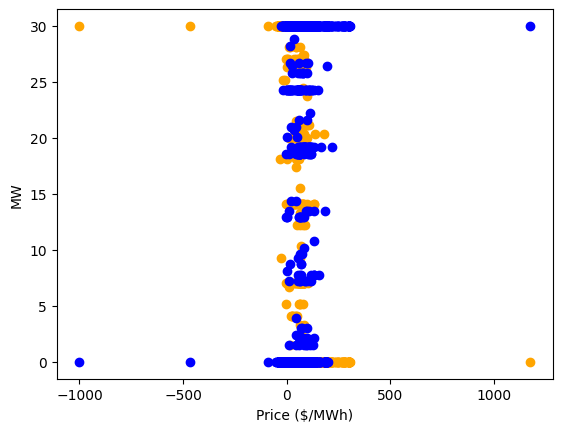

In [30]:
p = plt.scatter(nsw_energy_price, soln["charge_mw"], color="orange")
plt.scatter(nsw_energy_price, soln["discharge_mw"], color="blue")
plt.xlabel("Price ($/MWh)")
plt.ylabel("MW")

Text(0, 0.5, 'charge state')

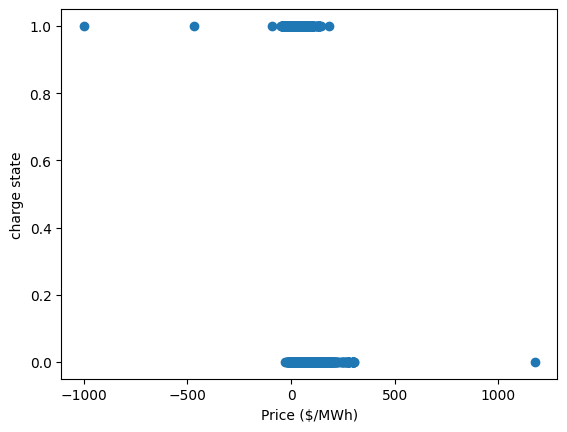

In [31]:
plt.scatter(nsw_energy_price, soln["charge_state"])
plt.xlabel("Price ($/MWh)")
plt.ylabel("charge state")